# Snapchat Political Ads

### Introduction
This projec is based on dataset Snap Political Ads Library which contains snapchat political ads records in 2018 and 2019. This project will contain three sections: Cleaning and EDA, Assessment of Misingness, Permuatation Test.

### Cleaning and EDA
Download datasets and join two tables. Caculating basic stats and trying to dig interesting things. 

In this sections, one problem is answerd:

    A: The increase of ads are mainly coming from new companies.
    
    
Two problems are raised:

    P1: Do companies who quit putting ads in 2019 have less average "Impressions" in 2018?
    P2: Do new joined companies in 2019 have lower average of spent money?

This two problems are gonna be answered in Section Permutation Test

### Assessment of Missingness
In this part, I analyzed the general information of whole missingness in ads, and did a permutation test for column 'DateEnd' to see if it is conditional depend on column 'Year'. Also, in order to see the relationship between time duaration and missingness of "DateEnd", I aggregated data and ploted a graph

### Permutation Test
Answers: 

    P1: Do companies who quit putting ads in 2019 have less average "Impressions" in 2018?
    
    A1: We have enough evidence to reject null hypothesis:
        the distributions of column Impressions when OrganizationName is in /not in quit_comp are the same, that distributions of column Impressions when OrganizationName is in quit_comp does not have a lower average
            
    P2: Do new joined companies in 2019 have lower average of spent money?
    A2:There is a high probability this is wrong and the inverse is true that new joined companies in 2019 have higher average of spend money. we have enough evidence to reject null hypothesis:
        the distributions of column Spend when OrganizationName is in /not in new_comp are the same, that distributions of column spend when OrganizationName is in new_comp does not have a higher average.

# Code

In [1]:
# Basic
import numpy as np
import os
import pandas as pd
import datetime
import math

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# string
import re

# machine learnning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from dateutil.rrule import rrule, DAILY
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Import and Clean

In [4]:
ads_2018 = pd.read_csv('data/2018.csv') #import data
ads_2019 = pd.read_csv('data/2019.csv') #import data
print(ads_2018.shape, ads_2019.shape)

(659, 27) (2659, 27)


In [5]:
## create a dataframe of columns' description based on readme.txt 

myfile = open("data/readme.txt")
readme = myfile.read()
myfile.close()
readme = readme.replace('Geo-Postal', 'Geo Postal')
readme = re.findall('[^\-\n]+\-[^\-\n]+', readme)
instruction = {}
for col in readme[:-2]:
    key = col.split(' - ')[0]
    val = col.split(' - ')[1]
    instruction[key] = val
instruction = pd.Series(instruction).to_frame()
instruction.head()

,0
AD ID,Unique identifier for each Political Ad
CreativeURL,URL link to creative content for the Ad
Spend,Amount (In USD) spent by the advertiser over t...
Impressions,Number of times the Ad has been viewed by Snap...
Start Date,The time at which the Ad was set up to start d...


In [9]:
## Combine two dataframe

ads_2018 = ads_2018.assign(Year=2018) # assign a column represent the year before concate
ads_2019 = ads_2019.assign(Year=2019)
ads = pd.concat([ads_2018, ads_2019], axis=0) # concate two dataframe
ads[['StartDate', 'EndDate']] = ads[['StartDate', 'EndDate']].apply(pd.to_datetime) # Convert StartDate and EndDate into datetime.
ads.head()

,ADID,CreativeUrl,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,PayingAdvertiserName,...,OsType,Segments,LocationType,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),Targeting Geo - Postal Code,CreativeProperties,Year
0,2ac103bc69cce2d24b198e6a6d052dbff2c25ae9b6bb9e...,https://www.snap.com/political-ads/asset/69afd...,165,49446,2018-11-01 22:42:22+00:00,2018-11-06 23:00:00+00:00,Bully Pulpit Interactive,"1140 Connecticut Ave NW, Suite 800,Washington,...",NaN,NextGen America,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://nextgenamerica.org/lookup...,2018
1,40ee7e900be9357ae88181f5c8a56baf6d5aab0e8d0f51...,https://www.snap.com/political-ads/asset/0885d...,17,23805,2018-11-15 15:52:06+00:00,2018-11-24 15:50:38+00:00,Amnesty International Switzerland,CH,NaN,Amnesty International,...,NaN,Provided by Advertiser,NaN,de,NaN,NaN,NaN,NaN,NaN,2018
2,c80ca50681d552551ceaf625981c0202589ca710d51925...,https://www.snap.com/political-ads/asset/a36b7...,60,12883,2018-09-28 23:10:14+00:00,2018-10-10 02:00:00+00:00,Chong and Koster,"1640 Rhode Island Ave. NW, Suite 600,Washingto...",NaN,Voter Participation Center,...,NaN,Provided by Advertiser,NaN,NaN,Marital Status (Single),NaN,NaN,NaN,web_view_url:https://www.voterparticipation.or...,2018
3,a3106af2289b62f57f63f4fb89753bdf94e2fadede0478...,https://www.snap.com/political-ads/asset/46819...,2492,377236,2018-10-27 19:23:19+00:00,2018-11-06 23:00:00+00:00,"Middle Seat Consulting, LLC","Po Box 21600,Washington,20009,US",NaN,Beto for Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://betofortexas.com/vote/?ut...,2018
4,7afda4224482eb70315797966b4dcdeb856df916df5bdc...,https://www.snap.com/political-ads/asset/ee833...,5795,467760,2018-10-25 04:00:00+00:00,2018-11-06 23:00:00+00:00,"Middle Seat Consulting, LLC","Po Box 21600,Washington,20009,US",NaN,Beto for Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


### Basic Stats and Found

In [6]:
## Take a look at how many ads each year has. 

n_unique_2018 = ads_2018['ADID'].nunique()
n_unique_2019 = ads_2019['ADID'].nunique()
print("n_unique_2018:", n_unique_2018)
print("n_unique_2019:", n_unique_2019)
print("Ratio:", (n_unique_2019 - n_unique_2018)/n_unique_2018)

n_unique_2018: 659
n_unique_2019: 2659
Ratio: 3.0349013657056148


#### 2019 has 3 times more ads, what about average 'Spend' and 'Impressions'?

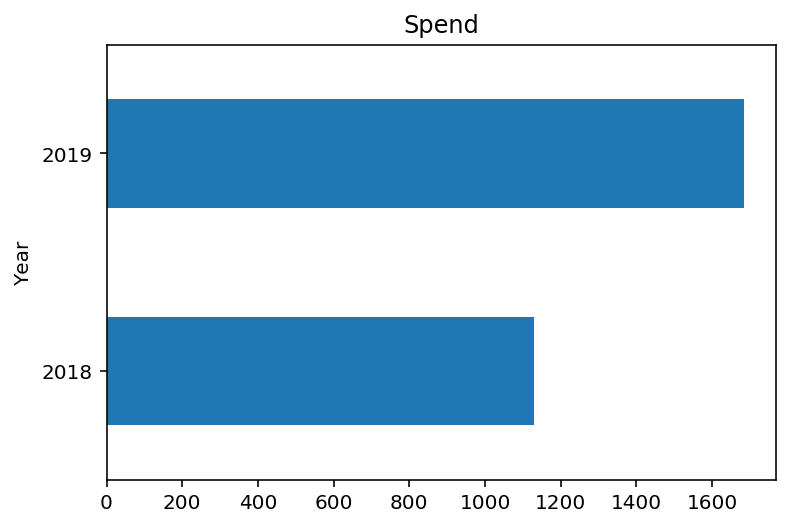

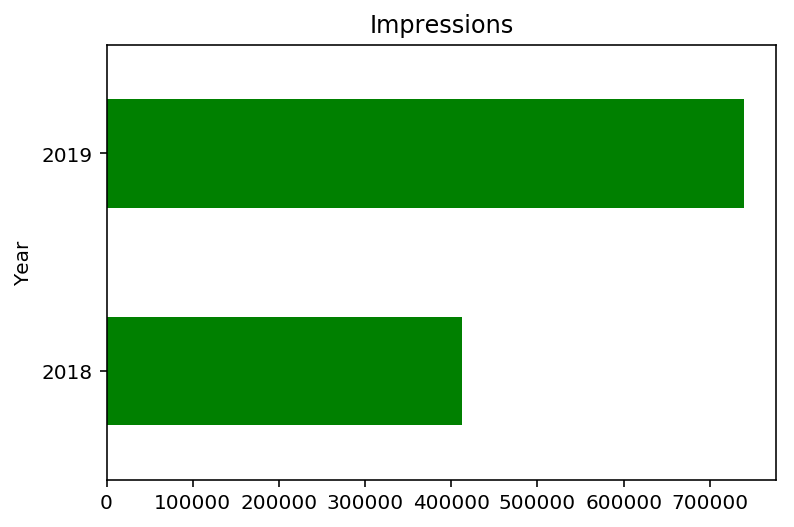

In [316]:
f1 = plt.figure(1)
g1 = ads.groupby('Year')['Spend'].apply(np.mean).plot(kind='barh', title='Spend')
f2 = plt.figure(2)
g2 = ads.groupby('Year')['Impressions'].apply(np.mean).plot(kind='barh', title='Impressions', color='G')
plt.show()

As we can see, not only the number of ads has increased, the average money spent and impressions' degree are all increased a lot from 2018 to 2019

Now, lee's take a look at the OrganizationName column to check 

    1. how many companies put ads for both years; 
    2. how many companies put ads in 2019 but not in 2018;
    3. which companies put most money and which companies put most ads for each year. 
    
Futhermore, let's figure out whether 2019 has more ads is because there are more new companies, or those old companies put more ads.

In [11]:
groups = ads.groupby('Year')['OrganizationName'] # get the groups
companies_2018 = (
    groups.get_group(2018)
    .value_counts().to_frame()
) # get the companies count of 2018
companies_2019 = (
    groups.get_group(2019)
    .value_counts().to_frame()
) # get the companies count of 2019
stats = {}
total = companies_2018.join(companies_2019, how='outer', lsuffix='_2018', rsuffix='_2019').fillna(0) # join two
total = total.assign(Difference=total['OrganizationName_2019'] - total['OrganizationName_2018']) # put the difference 

# companies in 2019 but not in 2018
new_comp = total.loc[(total['OrganizationName_2018'] == 0) & (total['OrganizationName_2019'] != 0)]

# companies in both years
both_comp = total.loc[(total['OrganizationName_2018'] != 0) & (total['OrganizationName_2019'] != 0)]

stats['increase_in_new'] = new_comp['Difference'].sum() # the increase caused by new companies
stats['increase_in_both'] = both_comp['Difference'].sum() # the increase casued by old companies

stats['increase_comp_num'] = new_comp.size # increase companies'number

stats['both_comp_num'] = both_comp.size #companies for both in 2018 and 2019

stats['highest_2018'] = companies_2018['OrganizationName'].idxmax() #the company which put most ads in 2018
stats['highest_2019'] = companies_2019['OrganizationName'].idxmax() #the company which put most ads in 2019

#number of companies who put ads in 2018 but not in 2019
stats['decrease_comp_num'] = total.loc[(total['OrganizationName_2018'] != 0) & (total['OrganizationName_2019'] == 0)].size
stats['increase_per_comp_new'] = stats['increase_in_new']/stats['increase_comp_num']
stats['increase_per_comp_both'] = stats['increase_in_both']/stats['both_comp_num']

# put all in a dataframe
stats_df = pd.Series(stats).to_frame()
stats_df = stats_df.rename(columns={0: 'stats'})
stats_df

,stats
increase_in_new,1748
increase_in_both,639
increase_comp_num,684
both_comp_num,90
highest_2018,Bully Pulpit Interactive
highest_2019,UnRestrict Minnesota
decrease_comp_num,225
increase_per_comp_new,2.55556
increase_per_comp_both,7.1


#### As we can see,
    1. The increase of ads are mainly caused by new companies. However, 
    2. The company who put most ads in 2018 is Bully Pulpit Interactive, and the The company who put most ads in 2019 is UnRestrict Minnesota
    3. There are 684 new companies, while only 225 companies that put ads in 2018 quit in 2019
  
  
Few new questions are raised?
A: Can we get some clues of the reason why those 225 companies quit?
    .Are they have a less average of impressions than other companies?

B: For new joined companies, are they more cautious? 
    .Do they have a lower average of spent money?
    
In the Permutation Test section, I will run test to see if we have enough evidence back up our guess.

### Assessment of Missingness

#### Let's first take a look of overall missingness information

In [318]:
missing = (
    ads
    .isna()
    .apply(sum)
    .sort_values(ascending=False) # sort the values in decreasing order
    .to_frame()
    .rename(columns={0: 'Num'}) # rename the column name 
)
print((missing["Num"] > 0).sum()) # number of columns which has missing values
missing

18


,Num
Targeting Carrier (ISP),3318
Targeting Connection Type,3318
LatLongRad,3318
LocationType,3300
OsType,3297
ElectoralDistrictID,3253
AdvancedDemographics,3222
MetroID,3138
CandidateBallotInformation,3086
Gender,2996


#### In readme.txt:

    Gender - Gender targeting criteria used in the Ad. If empty, then it is targeting all genders

    AgeBracket - Age targeting criteria used in the Ad. If empty, then it is targeting all ages
    
    RegionID - Region targeting criteria used in the Ad. This is sub-Country and often represents states or provinces. If empty, then it is targeting all regions in the Country targeted
    
    ElectoralDistrictID - Electoral districts targeting criteria used in the Ad. If empty, then it is targeting all electoral districts in the Country targeted
    
    LatLongRad - Point-radius targeting criteria used in the Ad. If empty, then it is targeting all lat/long in the Country targeted
    
    MetroID - Metro targeting criteria used in the Ad. This is sub-Country and often represents cities. If empty, then it is targeting all metros in the Country targeted
    
    Interests - Interest audience(s) targeting criteria used in the Ad. If empty, then it is agnostic to interests
    
    OsType - Operating system targeting criteria used in the Ad. If empty, then it is targeting all operating systems
    
    Language - Language targeting criteria used in the Ad. If empty, then it is agnostic to language
    
    AdvancedDemographics - 3rd party data segments targeting criteria used in the Ad. If empty, then it is agnostic to 3rd party data segments

    Target Connection Type - Internet connection type targeting criteria used in the Ad. If empty, then it is agnostic to internet connect type
    
    Targeting Carrier (ISP) - Carrier type targeting criteria used in the Ad. If empty, then it is agnostic to carrier type

    Targeting Geo-Postal Code - Postal code(s) targeting criteria used in the Ad. If empty, then it is targeting all postal codes in the Country targeted

    CreativeProperties - URL attachments specified in Ad’s call to action
    
All those columns are MD(Missing by Design), what we are insterested in are the left columns.


There will be 18 - 14 = 4 columns which we are not sure about the reason of missingness. They are:

    1. Location Type
    2. CandidateBallotInformation
    3. Segments
    4. EndDate
    
While for both Location Type and CandidateBallotInformation, there are over 3000 missing values while we only have 3000+ size data. The missing values are too much for us to analysis the reasons behind. There is a high possibilities that those two columns values' missingness is non-ignorable.

#### Let's take a look at columns 'Segments' and 'EndDate'

In [319]:
segments = ads['Segments']
end_date = ads['EndDate']

In [320]:
segments.fillna('Null').value_counts() # see what values that segments column has, fillna in order to put null value in compare

Provided by Advertiser    2202
Null                      1116
Name: Segments, dtype: int64

for simplicity, we will not take a look at the end_date values counts. They are just few dates...

#### Let's take a guess! Does the null values in end_date means that it is still not end till now (2019/11/13)? 

It is a very reasonable guess.
Let's see if we can find evidence for it

    If the missingness depends on the column Year, it will be a kinda proof for our guess.

In [321]:
null_2018 = ads.loc[ads["Year"] == 2018, 'EndDate'].isna().sum()
null_2019 = ads.loc[ads["Year"] == 2019, 'EndDate'].isna().sum()
print(null_2018, null_2019)

67 595


As we can see, there is a big difference between null_2018 and null_2019, but is this difference caused by randomness? or the missingness depends on column 'Year'

#### Let's run a permutation test:

    are the distributions of column Year when EndDate is Null/Not-Null different?
##### Null Hypothesis: 
    
    The distributions of column Year when EndDate is Null/Not-Null are the same (not different)
##### Alternative Hypothesis:
    
    The distributions of column Year when EndDate is Null/Not-Null are different (not same)
##### Static: number of null values for rows that column['Year] is 2019 - number of null values for rows that column['Year] is 2018
##### Significant Level: 0.95
##### observe static:

In [322]:
obs = null_2019 - null_2018
obs

528

##### Sampling under null hypothesis

In [323]:
stats = []
for i in range(1000):
    sample = (
        ads
        .assign(**{'isnull' : ads['EndDate'].isna()})
        .assign(**{'random' : ads['Year'].sample(frac=1, replace=False).reset_index(drop=True)})
        .groupby('random')['isnull']
        .sum()
        .to_dict()
    )
    stats.append(sample[2019] - sample[2018])

##### Calculate the p-value

In [324]:
p_value = (np.array(stats) <= obs).sum()/1000
p_value

1.0

##### Since p_value < 0.025, we reject the null hypothesis. Plot the stats for a better understanding

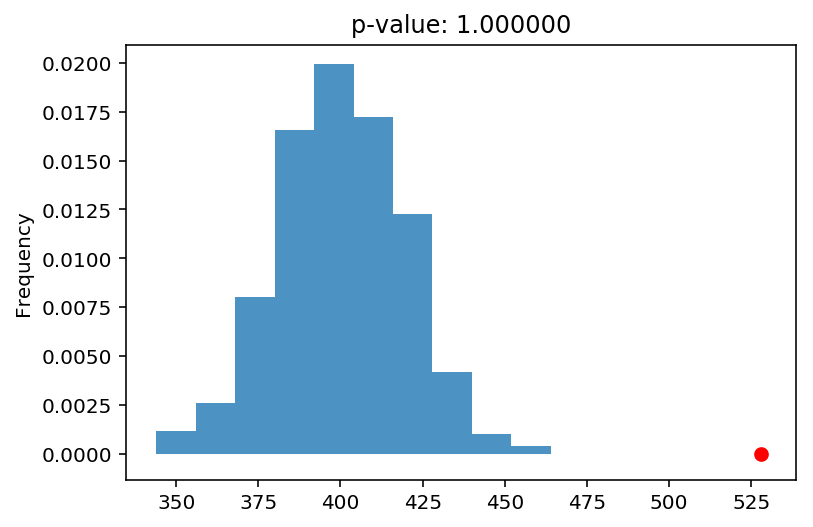

In [325]:
pd.Series(stats).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % p_value)
plt.scatter(obs, 0, color='red', s=40);

We have enough evidence to reject the null hypothesis, and we may can say that the missingness is depend on Year now. In some degree, this proves our guess:

    Since ads in 2019 are published later than ads in 2018 and EndDate column missingness do depend on Year column, there is a possibility that the null value in EndDate means it is still not end till now.
    
#### To further support our guess, lets divide the data into groups based on how many months since its start date to now and plot the disribution of missingness of EndDate

In [326]:
import datetime
from dateutil.rrule import rrule, MONTHLY
today = datetime.datetime.now(datetime.timezone.utc) # must be utc timezone
today # get today's date

datetime.datetime(2019, 11, 14, 8, 19, 39, 818182, tzinfo=datetime.timezone.utc)

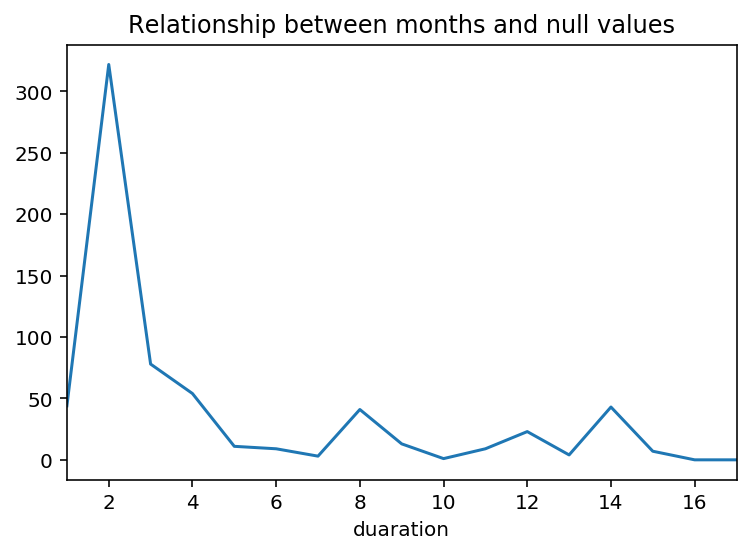

In [327]:
ads.assign(
    duaration = ads['StartDate'].apply(lambda x: len([dt for dt in rrule(MONTHLY, dtstart=x, until=today)]))
    is_null = ads['EndDate'].isna()
    ).groupby('duaration')['is_null'].sum().plot(title='Relationship between months and null values')

#### This graph do support our guess! The number of null values decrease through time, especially between 2 month and 6 month 

### Hypothesis Test

In [328]:
# data set up
new_comp = total.loc[(total['OrganizationName_2018'] == 0) & (total['OrganizationName_2019'] != 0)].index # new companies
quit_comp = total.loc[(total['OrganizationName_2018'] != 0) & (total['OrganizationName_2019'] == 0)].index # companies who quit

### First Test:
    P1: Do companies who quit putting ads in 2019 have less average "Impressions" in 2018?


#### Let's run a permutation test:

    Are the distributions of column Impressions when OrganizationName is in /not in quit_comp different? To be more specific, does distributions of column Impressions when OrganizationName is in quit_comp have a lower average?
##### Null Hypothesis: 
    
    the distributions of column Impressions when OrganizationName is in /not in quit_comp are the same, that distributions of column Impressions when OrganizationName is in quit_comp does not have a lower average
##### Alternative Hypothesis:
    
    the distributions of column Impressions when OrganizationName is in /not in quit_comp are different, and distributions of column Impressions when OrganizationName is in quit_comp has a lower average.
##### Static: mean_difference (mean of Impressions of rows that OrganizationName is in quit_comp - mean of Impressions of rows that OrganizationName is not in quit_comp
##### Significant Level: 0.95
##### observe static:

In [329]:
real = (
    ads
    .assign(isquit = ads['OrganizationName'].apply(lambda x: x in quit_comp))
    .groupby('isquit')['Impressions']
    .mean()
    .to_dict()
)
obs = real[True] - real[False]
obs

-415629.74443730345

##### Sampling under null hypothesis

In [330]:
stats = []
for i in range(1000):
    shuffle = (
        ads
        .assign(isquit = ads['OrganizationName'].apply(lambda x: x in quit_comp))
        .assign(shuffle = ads['Impressions'].sample(frac=1, replace=False).reset_index(drop=True))
        .groupby('isquit')['shuffle']
        .mean()
        .to_dict()
    )
    stats.append(shuffle[True] - shuffle[False])

##### Calculate p-value

In [331]:
p_value = (np.array(stats) <= obs).sum()/1000
p_value

0.0

0.0 < 0.025, We have enough evidence to reject our null hypothesis. 
##### plot the data

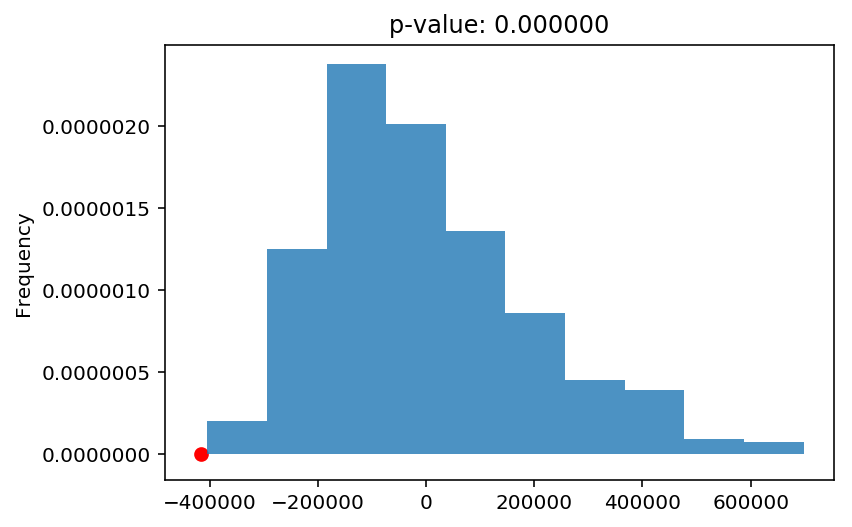

In [332]:
pd.Series(stats).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % p_value)
plt.scatter(obs, 0, color='red', s=40);

### Second Test:
    P2: Do new joined companies in 2019 have lower average of spent money?


#### Let's run a permutation test:

    Are the distributions of column Spend when OrganizationName is in /not in new_comp different? To be more specific, does distributions of column Spend when OrganizationName is in new_comp have a lower average?
##### Null Hypothesis: 
    
    the distributions of column Spend when OrganizationName is in /not in new_comp are the same, that distributions of column spend when OrganizationName is in new_comp does not have a lower average.
##### Alternative Hypothesis:
    
    the distributions of column Spend when OrganizationName is in /not in new_comp are different, and distributions of column Spend when OrganizationName is in new_comp has a lower average.
##### Static: mean_difference (mean of spend of rows that OrganizationName is in new_comp - mean of spend  of rows that OrganizationName is not in new_comp
##### Significant Level: 0.95
##### observe static:

In [333]:
real = (
    ads
    .assign(isnew = ads['OrganizationName'].apply(lambda x: x in new_comp))
    .groupby('isnew')['Spend']
    .mean()
    .to_dict()
)
obs = real[True] - real[False]
obs

1288.2467424098877

##### Sampling under null hypothesis:

In [334]:
stats = []
for i in range(1000):
    shuffle = (
        ads
        .assign(isnew = ads['OrganizationName'].apply(lambda x: x in new_comp))
        .assign(shuffle = ads['Spend'].sample(frac=1, replace=False).reset_index(drop=True))
        .groupby('isnew')['shuffle']
        .mean()
        .to_dict()
    )
    stats.append(shuffle[True] - shuffle[False])

##### Calculate p_value

In [335]:
p_value = (np.array(stats) <= obs).sum()/1000
p_value

1.0

Interesting! We have a 1.0 p_value if we calculate the p_value according to our current alternative hypothesis!


That means we are wrong!!!!


Instead of putting less money, new companies tends to spend more money on ads. Now, we change our hypothesis to:

##### Null Hypothesis: 
    
    the distributions of column Spend when OrganizationName is in /not in new_comp are the same, that distributions of column spend when OrganizationName is in new_comp does not have a higher average.
##### Alternative Hypothesis:
    
    the distributions of column Spend when OrganizationName is in /not in new_comp are different, and distributions of column Spend when OrganizationName is in new_comp has a higher average.
    
##### New p_value:

In [336]:
p_value = (np.array(stats) >= obs).sum()/1000
p_value

0.0

Now we reject our new null hypothesis.

##### Plot the data:

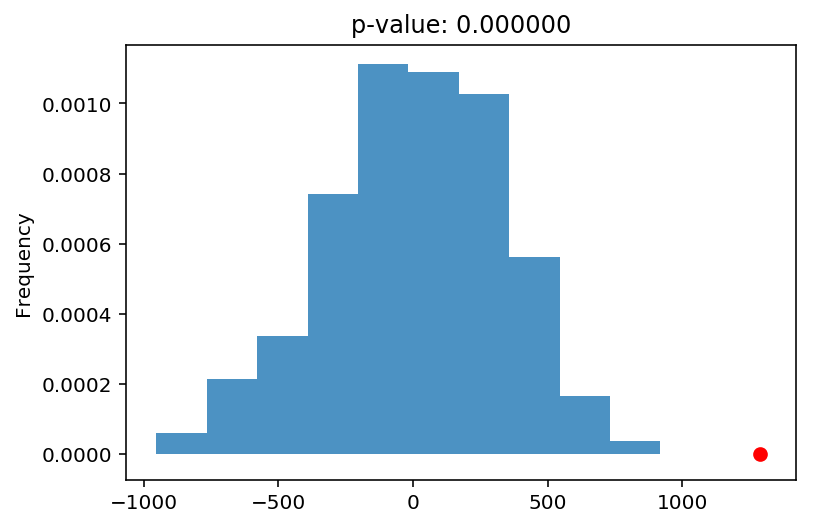

In [338]:
pd.Series(stats).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % p_value)
plt.scatter(obs, 0, color='red', s=40);